<a href="https://colab.research.google.com/github/elifsare/Real-time-Age-Gender-Ethnicity-Detection/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elifsare","key":"65fe5c557a5858f538b76c194afd0b9a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 96% 61.0M/63.2M [00:03<00:00, 25.0MB/s]
100% 63.2M/63.2M [00:03<00:00, 18.0MB/s]


In [4]:
!mkdir dataset

In [5]:
!unzip '/content/age-gender-and-ethnicity-face-data-csv.zip' -d dataset

Archive:  /content/age-gender-and-ethnicity-face-data-csv.zip
  inflating: dataset/age_gender.csv  


In [6]:
import numpy as np 
import pandas as pd

import tensorflow as tf
from keras.models import Sequential     
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D, Activation, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop, Adamax 
from keras.utils import np_utils  
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('/content/dataset/age_gender.csv')

In [8]:
## Converting pixels into numpy array
num_pixels = len(df['pixels'][0].split(" "))
img_height = int(np.sqrt(len(df['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(df['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


In [9]:
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(),dtype='float32'))

data visulate

In [10]:
df1 = df.drop('img_name', axis=1)
y1 = df1.drop("pixels", axis=1)

In [11]:
y1.nunique()

age          104
ethnicity      5
gender         2
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


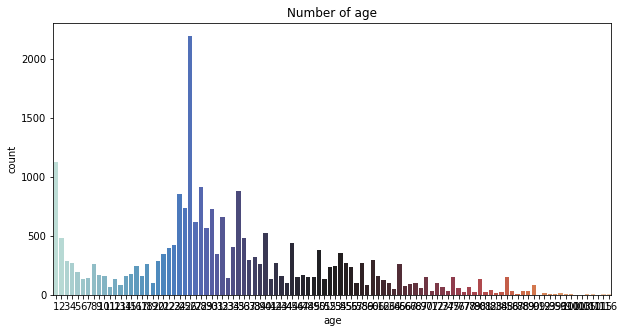

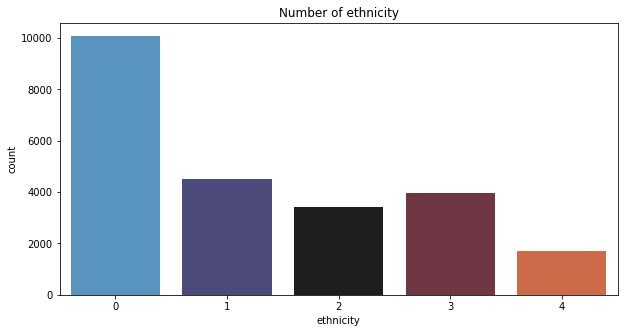

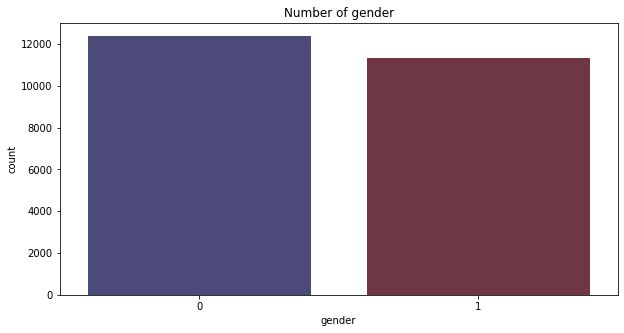

In [12]:
import seaborn as sns
for i in y1.columns:
    plt.figure(figsize=(10,5))
    g = sns.countplot(y1[i], palette="icefire")
    plt.title("Number of {}".format(i))

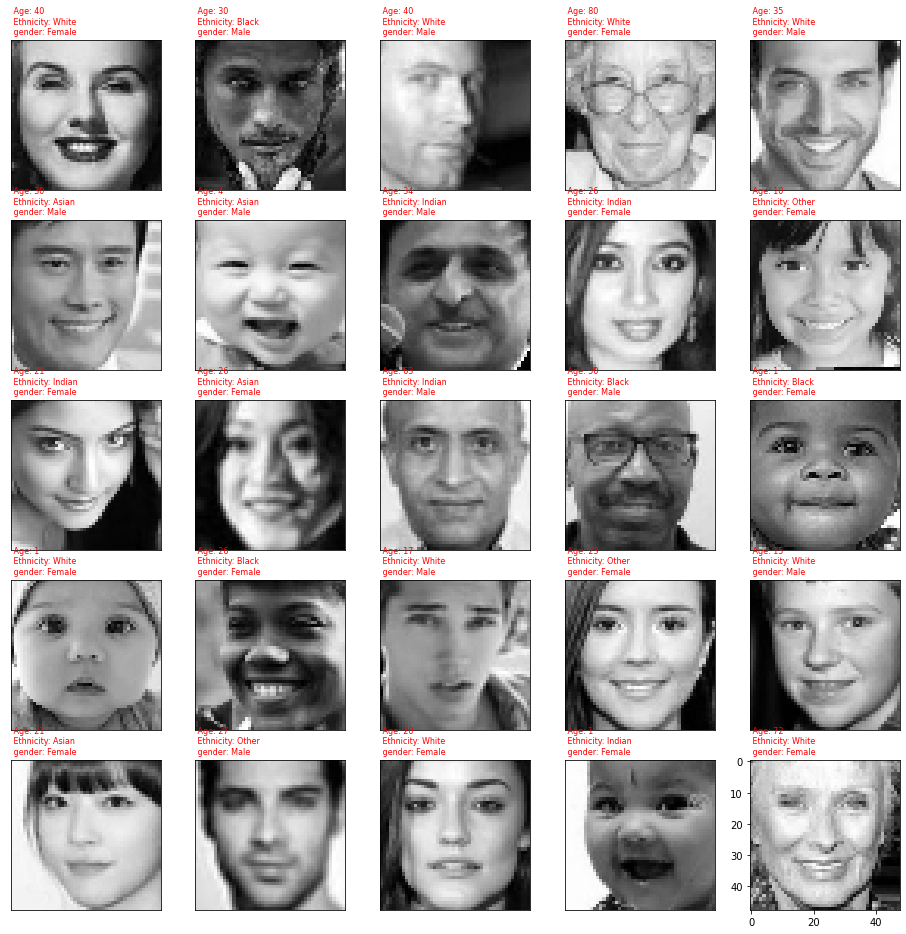

In [13]:
plt.figure(figsize=(16, 16))

for i in range(25):  
    index = np.random.randint(0, len(df))
    plt.xticks([])
    plt.yticks([])   
    plt.grid(False)
    plt.subplot(5, 5, i+1)
    plt.imshow(df['pixels'].iloc[index].reshape(48, 48),"gray")
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(df['age'].iloc[index], {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Other"}[df['ethnicity'].iloc[index]], {0:"Male", 1:"Female"}[df['gender'].iloc[index]]),loc="left",color='red',fontsize = 8)

plt.show()

In [14]:
X = np.array(df['pixels'].tolist())
X = np.reshape(X, (-1, 48, 48,1))

In [15]:
def m_subplot(h):
  plt.figure(figsize = (14,3))
  plt.subplot(1,2,1)
  plt.ylabel('Loss', fontsize = 15)
  plt.plot(h.history['loss'], color = 'b', label = 'Training Loss')
  plt.plot(h.history['val_loss'], color = 'r', label = 'Validation Loss')

  plt.subplot(1,2,2)
  plt.ylabel('Accuracy', fontsize = 15)
  plt.plot(h.history['accuracy'], color = 'b', label = 'Training Accuracy')
  plt.plot(h.history['val_accuracy'], color = 'r', label = 'Validation Accuracy')

  plt.legend(loc = 'lower right')

  plt.show()

Age Model

In [16]:
y = df['age']
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y, test_size=0.3, random_state=30)

image generetor

In [17]:
train_generator = ImageDataGenerator(width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    rescale = 1./255,
                                    validation_split = 0.2
                                    )
validation_generator = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [18]:
train_flow_age = train_generator.flow(X_test_age,
                                  y_test_age,
                                  batch_size=32)

validation_flow_age = validation_generator.flow(X_test_age,
                                            y_test_age,
                                            batch_size=32)

Checkpoint

In [19]:
root = '/content/drive/MyDrive/DeepLearningProject/Gender&Age/'
checkPointer = ModelCheckpoint(root + 'checkPoint_model_age.h5', verbose = 1, save_best_only = True)

overfitting engelliyoruz
EarlyStop

In [20]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=6,
                               verbose=1,
                               restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, checkPointer, reduce_learningrate]

In [21]:
model_age = Sequential()

model_age.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))

model_age.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_age.add(BatchNormalization())
model_age.add(MaxPooling2D((2, 2)))

model_age.add(Conv2D(64, (3, 3), activation='relu'))
model_age.add(MaxPooling2D((2, 2)))

model_age.add(Conv2D(128, (3, 3), activation='relu'))
model_age.add(MaxPooling2D((2, 2)))

model_age.add(Flatten())

model_age.add(Dense(64, activation='relu'))
model_age.add(Dropout(rate=0.2))

model_age.add(Dense(1, activation = 'relu'))

model_age.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])


model_age.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0

In [24]:
batch_size = 64
epochs = 60

In [25]:
h_age = model_age.fit(train_flow_age, 
                      epochs= epochs,
                      batch_size=batch_size,
                      validation_split=0.1,
                      validation_data= validation_flow_age,
                      callbacks= callbacks_list)

Epoch 1/60
222/223 [============================>.] - ETA: 0s - loss: 382.0317 - mae: 15.0510
Epoch 1: val_loss improved from inf to 1161.53760, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_age.h5
223/223 [==============================] - 15s 32ms/step - loss: 381.7510 - mae: 15.0481 - val_loss: 1161.5376 - val_mae: 28.4930 - lr: 0.0010
Epoch 2/60
223/223 [==============================] - ETA: 0s - loss: 269.3439 - mae: 12.5652
Epoch 2: val_loss improved from 1161.53760 to 567.53528, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_age.h5
223/223 [==============================] - 5s 24ms/step - loss: 269.3439 - mae: 12.5652 - val_loss: 567.5353 - val_mae: 18.9284 - lr: 0.0010
Epoch 3/60
223/223 [==============================] - ETA: 0s - loss: 220.0517 - mae: 11.3100
Epoch 3: val_loss improved from 567.53528 to 194.89226, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_m

In [26]:
train_loss, train_acc = model_age.evaluate(train_flow_age)
test_loss, test_acc   = model_age.evaluate(validation_flow_age)

223/223 [==============================] - 1s 5ms/step - loss: 59.5911 - mae: 5.7366


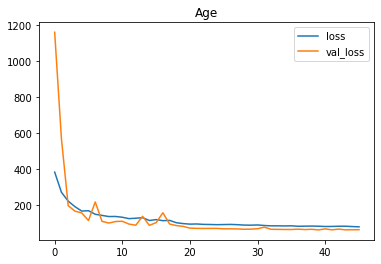

In [27]:
losses_age = pd.DataFrame(h_age.history)
losses_age[['loss','val_loss']].plot(title='Age')

Gender Model

In [28]:
y = df['gender']
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X,
                                                                                y, 
                                                                                test_size=0.3, 
                                                                                random_state=40)

image generetor

In [29]:
batch_size = 64
epoch = 60

In [30]:
train_flow_gender = train_generator.flow(X_test_gender,
                                  y_test_gender,
                                  batch_size=batch_size)

validation_flow_gender = validation_generator.flow(X_test_gender,
                                            y_test_gender,
                                            batch_size=batch_size)

In [31]:
root = '/content/drive/MyDrive/DeepLearningProject/Gender&Age/'
checkPointer = ModelCheckpoint(root + 'checkPoint_model_gender.h5', verbose = 1, save_best_only = True)

In [32]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=6,
                               verbose=1,
                               restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, checkPointer, reduce_learningrate]

In [33]:
model_gender = Sequential()

model_gender.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model_gender.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_gender.add(BatchNormalization())
model_gender.add(MaxPooling2D((2, 2)))

model_gender.add(Conv2D(64, (3, 3), activation='relu'))
model_gender.add(MaxPooling2D((2, 2)))

model_gender.add(Flatten())

model_gender.add(Dense(64, activation='relu'))
model_gender.add(Dropout(rate=0.5))
model_gender.add(Dense(1, activation='sigmoid'))

model_gender.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model_gender.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)      

In [34]:
h_gender = model_gender.fit(train_flow_gender, 
                            epochs= epochs,
                            batch_size = batch_size,
                            validation_split=0.1,
                            validation_data= validation_flow_gender,
                            callbacks= callbacks_list)

Epoch 1/60
112/112 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.6337
Epoch 1: val_loss improved from inf to 0.67781, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_gender.h5
112/112 [==============================] - 7s 51ms/step - loss: 0.6340 - accuracy: 0.6337 - val_loss: 0.6778 - val_accuracy: 0.6616 - lr: 0.0100
Epoch 2/60
111/112 [============================>.] - ETA: 0s - loss: 0.5806 - accuracy: 0.6969
Epoch 2: val_loss improved from 0.67781 to 0.64174, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_gender.h5
112/112 [==============================] - 5s 41ms/step - loss: 0.5813 - accuracy: 0.6967 - val_loss: 0.6417 - val_accuracy: 0.7518 - lr: 0.0100
Epoch 3/60
111/112 [============================>.] - ETA: 0s - loss: 0.5620 - accuracy: 0.7072
Epoch 3: val_loss improved from 0.64174 to 0.60305, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkP

In [35]:
train_loss, train_acc = model_gender.evaluate(train_flow_gender)
test_loss, test_acc   = model_gender.evaluate(validation_flow_gender)

112/112 [==============================] - 1s 7ms/step - loss: 0.3297 - accuracy: 0.8532


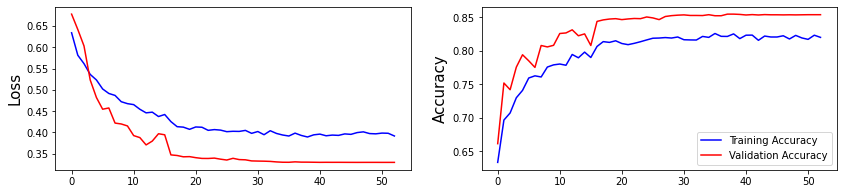

In [36]:
m_subplot(h_gender)

# Ethnicity model

In [37]:
y = df['ethnicity']

In [38]:
X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(X,
                                                                                            y,
                                                                                            test_size = 0.3,
                                                                                            random_state = 40)

image generetor

In [39]:
train_flow_ethnicity = train_generator.flow(X_test_ethnicity,
                                            y_test_ethnicity,
                                            batch_size=32)

validation_flow_ethnicity= validation_generator.flow(X_test_ethnicity,
                                                     y_test_ethnicity,
                                                     batch_size=32)

In [40]:
root = '/content/drive/MyDrive/DeepLearningProject/Gender&Age/'
checkPointer = ModelCheckpoint(root + 'checkPoint_model_ethnicity.h5', verbose = 1, save_best_only = True)

In [41]:
model_ethnicity = Sequential()

model_ethnicity.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))

model_ethnicity.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_ethnicity.add(MaxPooling2D((2, 2)))

model_ethnicity.add(Conv2D(64, (3, 3), activation='relu'))
model_ethnicity.add(MaxPooling2D((2, 2)))

model_ethnicity.add(Flatten())

model_ethnicity.add(Dense(64, activation='relu'))
model_ethnicity.add(Dropout(rate=0.2))

model_ethnicity.add(Dense(5))

model_ethnicity.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model_ethnicity.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6400)             

In [42]:
h_ethnicity = model_ethnicity.fit(train_flow_ethnicity, 
                                  epochs= epochs,
                                  batch_size=batch_size,
                                  validation_split=0.1,
                                  validation_data= validation_flow_ethnicity,
                                  callbacks= callbacks_list)

Epoch 1/60
221/223 [============================>.] - ETA: 0s - loss: 1.3972 - accuracy: 0.4492
Epoch 1: val_loss did not improve from 0.32974
223/223 [==============================] - 6s 24ms/step - loss: 1.3980 - accuracy: 0.4485 - val_loss: 1.3104 - val_accuracy: 0.5346 - lr: 0.0010
Epoch 2/60
223/223 [==============================] - ETA: 0s - loss: 1.2724 - accuracy: 0.4980
Epoch 2: val_loss did not improve from 0.32974
223/223 [==============================] - 5s 24ms/step - loss: 1.2724 - accuracy: 0.4980 - val_loss: 1.1062 - val_accuracy: 0.5723 - lr: 0.0010
Epoch 3/60
223/223 [==============================] - ETA: 0s - loss: 1.1726 - accuracy: 0.5548
Epoch 3: val_loss did not improve from 0.32974
223/223 [==============================] - 5s 24ms/step - loss: 1.1726 - accuracy: 0.5548 - val_loss: 1.0300 - val_accuracy: 0.6161 - lr: 0.0010
Epoch 4/60
222/223 [============================>.] - ETA: 0s - loss: 1.1085 - accuracy: 0.5794
Epoch 4: val_loss did not improve from 0

In [43]:
train_loss, train_acc = model_ethnicity.evaluate(train_flow_ethnicity)
test_loss, test_acc   = model_ethnicity.evaluate(validation_flow_ethnicity)

223/223 [==============================] - 1s 5ms/step - loss: 0.5925 - accuracy: 0.7880


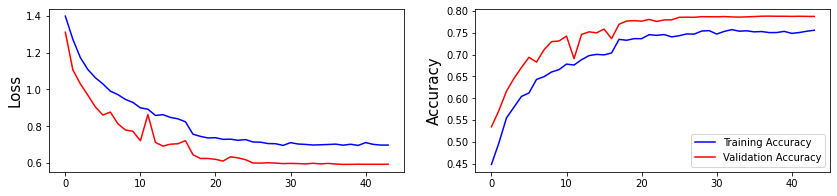

In [44]:
m_subplot(h_ethnicity)